In [12]:
import numpy as np
import pickle, h5py
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
embedding_model = 'NeuTraj-Adversarial'
embedding_size = 128
num_layers = 3
hidden_size = 128

partition = 't2vec_partition'

In [14]:
if partition == 'new_partition':
    vocab_dist_cell = h5py.File("porto-vocab-dist-cell75.h5", "r")
    D = vocab_dist_cell['D']
    V = vocab_dist_cell['V']
else:
    vocab_dist_cell = h5py.File("porto-vocab-dist-cell100.h5", "r")
    D = vocab_dist_cell['D']
    V = vocab_dist_cell['V']

In [15]:
def get_neighbours(trg,V):
    neighbours = []
    for cell in trg:
        neighbours += list(V[cell])
    return neighbours


In [16]:
def del_zero(trj):
    while 0 in trj:
        trj.remove(0)
    while 3 in trj:
        trj.remove(3)
    return trj

In [17]:
with open('inversions_{}_{}_{}_{}_{}_100000'.format(embedding_model, str(embedding_size), num_layers, hidden_size, partition), 'rb') as f:
    inversions = pickle.load(f)
print(len(inversions))
print(inversions[0])

10000
[619 643 643 119 119 365 365 365 365  63  63  63   0   0   0   0   0   0
   0   0]


In [18]:
# 考虑原轨迹邻居的预测轨迹准确率
precision = []
with open("../data/target/{}/test-real.trg".format(partition), "r") as f:
    i = 0
    for line in f:
        i += 1
        in_count = 0
        trg = [int(x) for x in line.split()]
        trg = del_zero(trg)
        if len(trg) == 0:
            print("trg", i)
            continue

        pre = inversions[i-1]
        pre = [int(x) for x in pre]
        pre = del_zero(pre)
        pre = list(set(pre))
        
        len_pre = len(pre)
        
        if len(pre) == 0:
            print("pre", i)
            continue

        neighbours = get_neighbours(trg, V)

        for cell in pre:
            if cell in neighbours:
                in_count += 1
        precision.append(in_count/len_pre)
        
        if i % 1000 == 0:
            print(i)

1000
2000
pre 2997
3000
pre 3205
pre 3373
pre 3378
4000
pre 4128
pre 4770
5000
pre 5729
6000
pre 6683
7000
8000
9000
pre 9961
10000


In [19]:
# 考虑最近邻的预测轨迹准确率
print(sum(precision)/len(precision))

0.5524731493553414


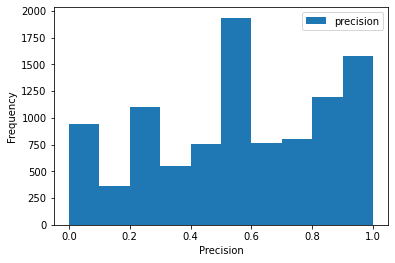

In [20]:
precision = np.asarray(precision)
df = pd.DataFrame({"precision": precision})
hist = df.plot.hist(bins=10)
plt.xlabel('Precision')
plt.ylabel('Frequency')
plt.show()

In [21]:
# 考虑原轨迹邻居的召回率

recall = []

with open("../data/target/{}/test-real.trg".format(partition), "r") as f:
    i = 0
    for line in f:
        i += 1
        in_count = 0
        trg = [int(x) for x in line.split()]
        trg = del_zero(trg)
        trg = list(set(trg))
        if len(trg) == 0:
            print("trg", i)
            continue

        len_trg = len(trg)

        pre = inversions[i-1]
        pre = [int(x) for x in pre]
        pre = del_zero(pre)
        pre = list(set(pre))
        
        if len(pre) == 0:
            print("pre", i)
            continue

        for cell in trg:
            neighbours = V[cell]
            for neighbour in neighbours:
                if neighbour in pre:
                    in_count += 1
                    break
        
        recall.append(in_count/len_trg)
        if i%1000 == 0:
            print(i)

1000
2000
pre 2997
3000
pre 3205
pre 3373
pre 3378
4000
pre 4128
pre 4770
5000
pre 5729
6000
pre 6683
7000
8000
9000
pre 9961
10000


In [22]:
# 考虑原轨迹邻居的情况下的召回率
print(sum(recall)/len(recall))

0.18013984223075105


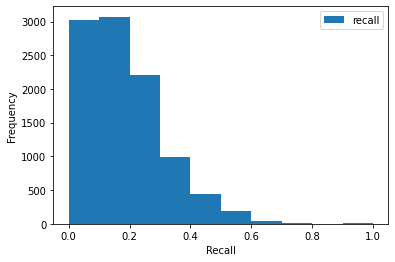

In [23]:
recall = np.asarray(recall)
df = pd.DataFrame({"recall": recall})
hist = df.plot.hist(bins=10)
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.show()